# Pneumonia X-Ray detection

## Import Libraries

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

## Download pneumonia dataset

The dataset will be placed in the `dataset` folder, with the following tree structure:
```
├── dataset
│   └── chest_xray
│       ├── chest_xray
│       │   ├── test
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   ├── train
│       │   │   ├── NORMAL
│       │   │   └── PNEUMONIA
│       │   └── val
│       │       ├── NORMAL
│       │       └── PNEUMONIA
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Setup kaggle with kaggle.json in "MyDrive" ("Il Mio Drive") folder

# install the Kaggle library
!pip install kaggle

# make a directory named “.kaggle”
!mkdir ~/.kaggle

# copy the “kaggle.json” into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

# allocate the required permission for this file
!chmod 600 ~/.kaggle/kaggle.json

# download pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# unzip it into dataset folder
!mkdir dataset
!unzip chest-xray-pneumonia.zip -d dataset


Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: dataset/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: da

## Import and explore data

In [3]:
print("importing dataset...")

data_dir = Path('dataset/chest_xray/chest_xray')
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

def load_set_from_dir(base_dir: Path):
  normal_dir = base_dir / 'NORMAL'
  normal_cases = normal_dir.glob('*.jpeg')
  pneumonia_dir = base_dir / 'PNEUMONIA'
  pneumonia_cases = pneumonia_dir.glob('*.jpeg')

  data = []
  label = []
  
  for sample in normal_cases:
    data.append(sample)
    label.append('NORMAL')
  for sample in pneumonia_cases:
    data.append(sample)
    label.append('PNEUMONIA')
  
  df = pd.DataFrame(data)
  df.rename(columns = {0 : 'image'}, inplace=True)  
  df['label'] = label

  # shuffle the data
  df = df.sample(frac=1).reset_index(drop=True)

  return df

print("loading train...")
train_data = load_set_from_dir(train_dir)
print("loading validation...")
val_data = load_set_from_dir(val_dir)
print("loading test...")
test_data = load_set_from_dir(test_dir)
print("\neverything loaded.")


importing dataset...
loading train...
loading validation...
loading test...

everything loaded.


In [4]:
# explore the data

print('train data infos:\n')
# print(train_data.info())
# print()
print(train_data['label'].value_counts())
print("""
!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
      """)
print()
print(train_data.head(3))
print('\n...')
print(train_data.tail(2))
print()


train data infos:

PNEUMONIA    3875
NORMAL       1341
Name: label, dtype: int64

!!!
This doesn’t look good, our trainig data is imbalanced. 
The number of images containing pneumonia is three times the number of normal images. 
Honestly, this is a fundamental problem with most medical datasets out there, 
as the people who go to a doctor with an ailment mostly have one.
!!!
      

                                               image      label
0  dataset/chest_xray/chest_xray/train/NORMAL/IM-...     NORMAL
1  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA
2  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA

...
                                                  image      label
5214  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA
5215  dataset/chest_xray/chest_xray/train/PNEUMONIA/...  PNEUMONIA



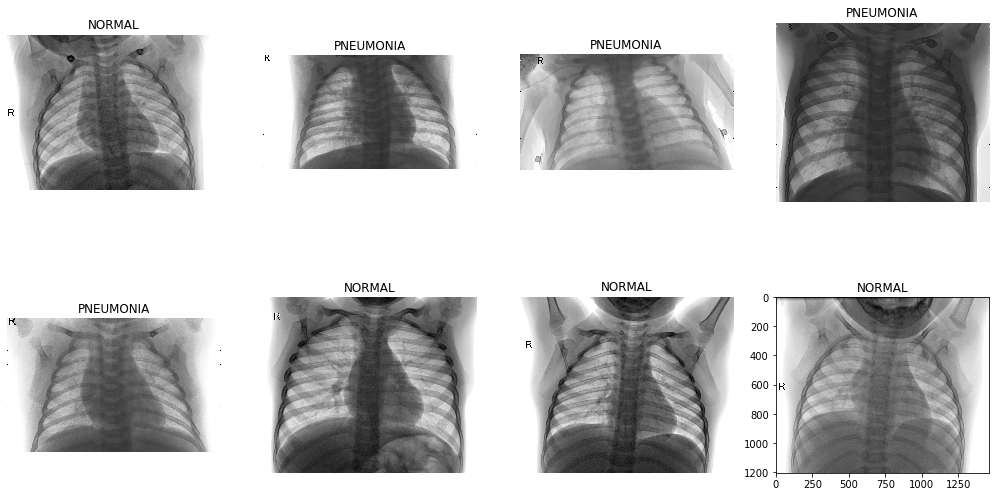

In [5]:
# display some sample images

n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 4.4, n_rows * 4.6))
for row in range(n_rows):
    for col in range(n_cols):
        position = n_cols * row + col
        plt.axis('off')
        plt.subplot(n_rows, n_cols, position + 1)
        image = plt.imread(train_data['image'].iloc[position])
        plt.imshow(image, cmap="binary", interpolation="nearest")
        title = train_data['label'].iloc[position]
        plt.title(title)
plt.show()


## Preprocessing

In [20]:
#convert dataframes to numpy array
train_set = train_data.to_numpy()
val_set = val_data.to_numpy()
test_set = test_data.to_numpy()

In [8]:
#convert path object to images of a given dimension (HEIGHT, WIDTH)
#Split the dataset into X_set and y_set and returns them
def convert_dataset(data, dimension):
  image_data = []
  label_data = []
  labels = {'PNEUMONIA': 1, 'NORMAL': 0}
  for i in range(data.shape[0]):
    image = np.array(Image.open(str(data[i, 0])))
    image = np.resize(image, dimension)
    image = image.astype('float32')
    image /= 255
    image_data.append(image)
    label_data.append(labels[data[i, 1]])

  return np.array(image_data).astype('float32'), np.array(label_data).astype('uint8')

In [42]:
#image dimension
dimension = (200, 200)

#convert datasets
X_train_val, y_train_val = convert_dataset(train_set, dimension)
X_test, y_test = convert_dataset(test_set, dimension)

#since val_set has only 16 elements, create it from train_val_set
X_train, y_train = X_train_val[:4700], y_train_val[:4700]
X_val, y_val = X_train_val[4700:], y_train_val[4700:]

In [43]:
#number of samples in all the three sets
print('Number of samples')
print('Training set: {}\nValidation set: {}\nTest set: {}'.format(X_train.shape[0], X_val.shape[0], X_test.shape[0]))

Number of samples
Training set: 4700
Validation set: 516
Test set: 624


## Model definition

In [10]:
import tensorflow as tf
from tensorflow import keras

In [44]:
#add 1 dimension to the image shape
input_shape = (dimension[0], dimension[1], 1)

basic_model = tf.keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=input_shape),
              tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
              tf.keras.layers.MaxPool2D(pool_size=(3, 3)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(100, activation='relu'),
              tf.keras.layers.Dense(1, activation='sigmoid')
])

basic_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

basic_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 66, 66, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 21, 21, 16)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 7056)              0         
                                                                 
 dense_12 (Dense)            (None, 100)              

## Training

Basic Model training

In [45]:
history = basic_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
147/147 [==============================] - 7s 40ms/step - loss: 0.3769 - accuracy: 0.8274 - val_loss: 0.2967 - val_accuracy: 0.8818
Epoch 2/50
147/147 [==============================] - 5s 37ms/step - loss: 0.2473 - accuracy: 0.8947 - val_loss: 0.2556 - val_accuracy: 0.8895
Epoch 3/50
147/147 [==============================] - 5s 37ms/step - loss: 0.2259 - accuracy: 0.9045 - val_loss: 0.1915 - val_accuracy: 0.9225
Epoch 4/50
147/147 [==============================] - 5s 37ms/step - loss: 0.2239 - accuracy: 0.8998 - val_loss: 0.1855 - val_accuracy: 0.9244
Epoch 5/50
147/147 [==============================] - 5s 37ms/step - loss: 0.1969 - accuracy: 0.9140 - val_loss: 0.1726 - val_accuracy: 0.9302
Epoch 6/50
147/147 [==============================] - 5s 37ms/step - loss: 0.1819 - accuracy: 0.9245 - val_loss: 0.1800 - val_accuracy: 0.9341
Epoch 7/50
147/147 [==============================] - 5s 37ms/step - loss: 0.1644 - accuracy: 0.9311 - val_loss: 0.1952 - val_accuracy: 0.9225

Plot accuracy and loss based on epochs

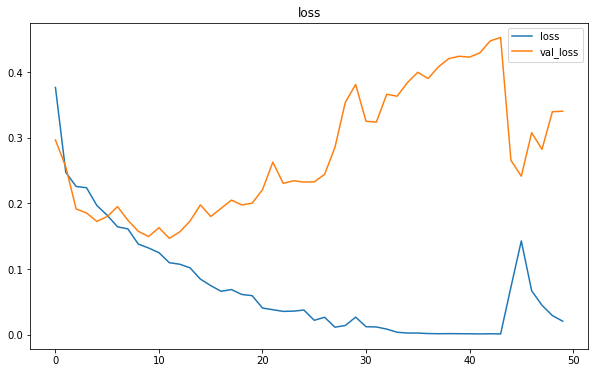

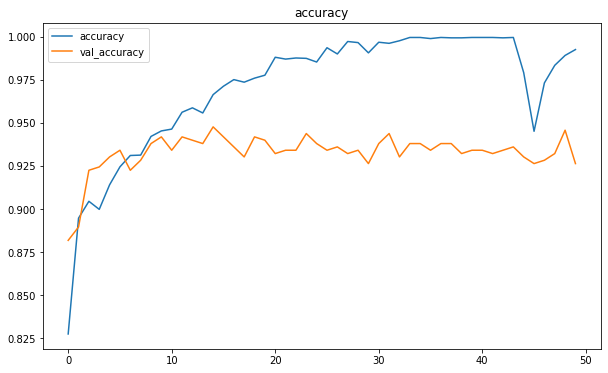

In [46]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
  
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()
  
#plot graphics
plot_loss(history)
plot_accuracy(history)

## Model evaluation